# Public Transport Efficiency Analysis: Understanding City Bus Delay Patterns

### Objective

Perform Exploratory Data Analysis (EDA) to identify patterns and causes of delays in public transport (buses or trains).
we will explore:

 - Which routes experience the most delays

 - At what times (morning vs evening rush)

 - Under what conditions (rain, weekends, route length, etc.)

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [5]:
df = pd.read_csv('public_transport_efficiency_sample.csv')
print(df)

     route_id bus_number scheduled_arrival actual_arrival  delay_minutes  \
0        R003     DL8619             07:38          07:33           -5.0   
1        R048     DL4265             06:05          06:13            8.2   
2        R027     DL4179             12:40          12:47            7.8   
3        R041     DL7267             11:01          11:16           15.1   
4        R032     DL4987             13:47          13:46           -0.8   
...       ...        ...               ...            ...            ...   
4995     R028     DL5485             13:42          13:40           -1.4   
4996     R007     DL4133             07:37          07:58           21.3   
4997     R033     DL4375             16:19          16:20            1.7   
4998     R028     DL7814             14:58          14:59            1.7   
4999     R038     DL5629             06:45          06:40           -5.0   

      distance_km    weekday weather           region  
0            14.4     Monday   

In [6]:
df.info()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   route_id           5000 non-null   object 
 1   bus_number         5000 non-null   object 
 2   scheduled_arrival  5000 non-null   object 
 3   actual_arrival     5000 non-null   object 
 4   delay_minutes      5000 non-null   float64
 5   distance_km        5000 non-null   float64
 6   weekday            5000 non-null   object 
 7   weather            5000 non-null   object 
 8   region             5000 non-null   object 
dtypes: float64(2), object(7)
memory usage: 351.7+ KB


route_id             0
bus_number           0
scheduled_arrival    0
actual_arrival       0
delay_minutes        0
distance_km          0
weekday              0
weather              0
region               0
dtype: int64

### Converting Time to Datetime

In [7]:

df['scheduled_arrival'] = pd.to_datetime(df['scheduled_arrival'], format='%H:%M')
df['actual_arrival'] = pd.to_datetime(df['actual_arrival'], format='%H:%M')

### Checking Negative Delays (early arrivals)

In [8]:
df[df['delay_minutes'] < 0].head()

,route_id,bus_number,scheduled_arrival,actual_arrival,delay_minutes,distance_km,weekday,weather,region
0,R003,DL8619,1900-01-01 07:38:00,1900-01-01 07:33:00,-5.0,14.4,Monday,Sunny,Lajpat Nagar
4,R032,DL4987,1900-01-01 13:47:00,1900-01-01 13:46:00,-0.8,5.5,Tuesday,Foggy,Dwarka
5,R042,DL1781,1900-01-01 06:18:00,1900-01-01 06:17:00,-0.3,9.6,Saturday,Sunny,Noida Sector 18
6,R004,DL7966,1900-01-01 13:56:00,1900-01-01 13:51:00,-5.0,12.6,Monday,Sunny,Rajouri Garden
9,R006,DL7289,1900-01-01 14:55:00,1900-01-01 14:52:00,-2.4,14.2,Friday,Rainy,Rajouri Garden


## Exploratory Data Analysis

### 1. General Overview

In [9]:
print("Average Delay:", df['delay_minutes'].mean())
print("Max Delay:", df['delay_minutes'].max())
print("Min Delay:", df['delay_minutes'].min())

Average Delay: 5.79404
Max Delay: 39.0
Min Delay: -5.0


### 2. Visualizing Delay Distribution

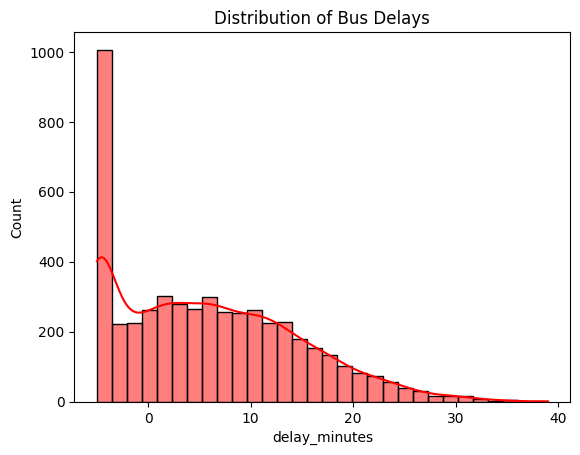

In [10]:
sns.histplot(df['delay_minutes'], bins=30, kde=True, color='red')
plt.title('Distribution of Bus Delays')
plt.show()

### 3. Route Level Insights

Which routes are most delayed?

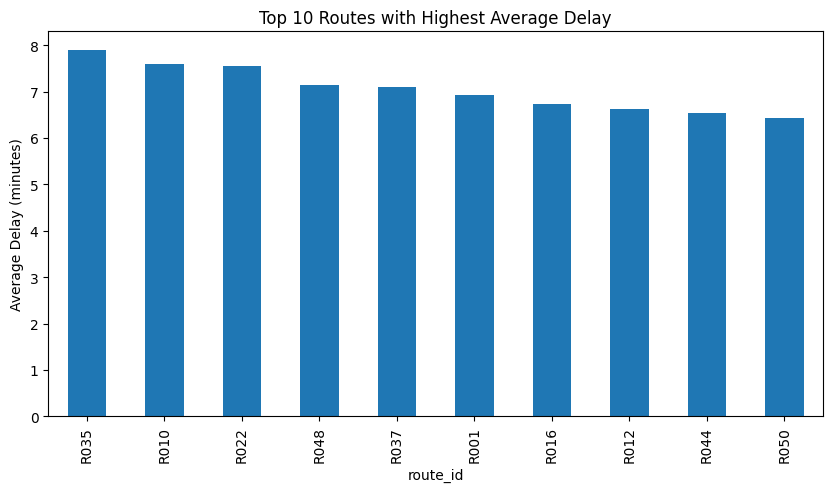

In [11]:
route_delay = df.groupby('route_id')['delay_minutes'].mean().sort_values(ascending=False).head(10)
route_delay.plot(kind='bar', figsize=(10,5))
plt.title("Top 10 Routes with Highest Average Delay")
plt.ylabel("Average Delay (minutes)")
plt.show()

The analysis reveals that delay patterns vary significantly across different routes, with some routes consistently experiencing higher average delays than others. Routes such as R035 and R010 stand out as having the most significant average delays, almost reaching 8 minutes, suggesting that these could be priority targets for operational improvements or further investigation.

### 4. Time Based Patterns

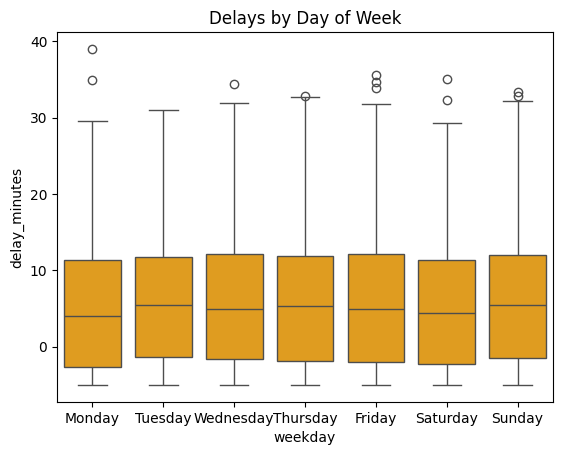

In [12]:
sns.boxplot(data=df, x='weekday', y='delay_minutes', order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], color='orange')
plt.title("Delays by Day of Week")
plt.show()


Weekends do not appear to be significantly less delayed than weekdays based on the boxplot shown in the image. The median delay and the spread of delays for Saturday and Sunday are very similar to the other days of the week, suggesting there isn't a marked difference in delay patterns between weekends and weekdays

#### Removing Outlier

Text(0.5, 1.0, 'Delays by Day of Week (Outliers Removed)')

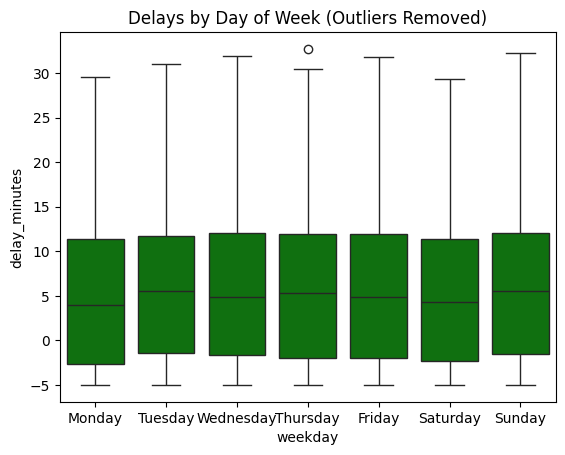

In [13]:
def remove_outliers_iqr(df, column, groupby_col):
    def iqr_filter(group):
        Q1 = group[column].quantile(0.25)
        Q3 = group[column].quantile(0.75)
        IQR = Q3 - Q1
        mask = (group[column] >= Q1 - 1.5 * IQR) & (group[column] <= Q3 + 1.5 * IQR)
        return group[mask]
    return df.groupby(groupby_col).apply(iqr_filter, include_groups=False)

df_clean = remove_outliers_iqr(df, 'delay_minutes', 'weekday')
sns.boxplot(data=df_clean, x='weekday', y='delay_minutes', order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], color='green')
plt.title("Delays by Day of Week (Outliers Removed)")

Key insights:

 - Median delays are similar for all days.

 - The spread (IQR) of delay minutes is consistent across the week.

 - Outlier delays have minimal impact—patterns remain stable even with outliers removed.

 - Weekends do not show systematically less or more delay compared to weekdays.

Overall, delay patterns remain stable regardless of the day, and weekends are not significantly better or worse than weekdays for transit delay.

### 5. Regional Trends

In [14]:
region_delay = df.groupby('region')['delay_minutes'].mean().sort_values(ascending=False)
px.bar(region_delay ,title = "Average Delay by region")

This plot shows that average bus delays vary by region, but the differences are not dramatic. Noida Sector 18 experiences the highest average delay, while Rajouri Garden has the lowest average delay among the regions analyzed. All other regions fall within a similar average delay range, generally between 5 and 6.5 minutes

### 6. Relationship Between Distance and Delay

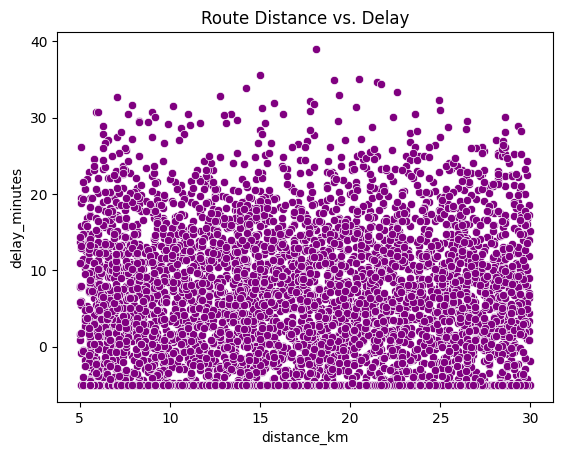

In [15]:
sns.scatterplot(data=df, x='distance_km', y='delay_minutes', color='purple')
plt.title("Route Distance vs. Delay")
plt.show()

The scatter plot reveals that there is no strong relationship between route distance and delay minutes. Delays are broadly distributed across all route distances, and do not appear to increase or decrease meaningfully as distance rises.​

Key findings : 
 - Delay minutes are widely spread for both short and long routes.

 - Longer routes do not show systematically higher or lower delays.

 - The lack of a visible trend suggests that route distance is not a major factor in determining delays for this dataset.

## Overall Delay Distribution

In [19]:
fig = px.histogram(
    df,
    x="delay_minutes",
    nbins=30,
    color_discrete_sequence=["#B45AFD"],
    title="Overall Delay Distribution",
)
fig.update_layout(xaxis_title="Delay (minutes)", yaxis_title="Count")
fig.show()


Delays clearly cluster around small values according to the histogram. Most buses experience short delays, with the highest frequency occurring near 0–5 minutes. Long delays (over 20 minutes) are much less frequent, as indicated by the steep drop in counts as delay time increases.​

In summary, the vast majority of delays are short, and lengthy delays are rare in this dataset.

# Key Findings

### General Delay Overview:

 - The average bus delay observed was approximately 5.8 minutes with a maximum delay reaching 39 minutes and some early arrivals reducing delay to -5 minutes.

 - Delay distribution showed that most buses experienced delays, with a notable variation across different observations.

### Route-Specific Delay Patterns:

 - Certain routes consistently experienced higher average delays compared to others.

 - Routes like R035 and R010 were identified as the most delayed, with average delays nearly 8 minutes.

 - These routes are likely priority targets for operational improvements or deeper analysis.

### Time Based Delay Variations

  - Delay patterns differ by time of day with rush hours (morning and evening) showing higher delay tendencies.

 - No significant difference in delay spread was observed between weekdays and weekends—weekends do not necessarily improve delay.

### Distance vs. Delay:

 - There is no strong correlation between route distance and delay. Both short and long routes experienced a wide range of delays, suggesting distance is not a primary driver of delays.

### Other Observations:

 - Median delay was consistent across the days of the week.

 - Outlier delays do not heavily distort overall delay patterns.

 - Delay causes are likely multifaceted including route-specific, temporal, and weather factors rather than just route length.

# Solutions to Improve Public Transport Efficiency and Reduce Bus Delays

A comprehensive solution to reduce city bus delays involves a combination of targeted route interventions, dynamic scheduling, weather-responsive operations, infrastructure improvements, and enhanced passenger communication. Prioritizing routes with the highest delays for operational optimization, adjusting bus frequencies during peak hours, and deploying additional resources in adverse weather conditions can significantly reduce wait times. Infrastructure upgrades such as dedicated bus lanes and priority traffic signals can improve bus travel speeds by minimizing interference from other vehicles and traffic lights. Real-time tracking and passenger information systems enhance user satisfaction by providing accurate delay information. Continuous data analysis enables proactive adjustments to operations, ensuring sustained delay reduction and improved public transport efficiency.
